## 6  Project guidelines

Your goal is to:

1. **Select the single most suitable municipality** based on a well-structured, reproducible spatial analysis.
2. **Within the selected municipality**, identify and map the **best local area** (polygon) where the project (crop, school, hospital, other facility) should be implemented.

Your final output will therefore include **two levels of analysis**:

- Level 1 — **Municipality ranking** based on multi-criteria analysis.
- Level 2 — **Intra-municipality spatial analysis** to identify the best location within the selected municipality.

## 6.1 Data preparation & CRS

Importamos las librerías necesarias y cargamos las capas base. Todas las capas se reproyectan al sistema de referencia EPSG:9377 (Magna Sirgas Origen Nacional).


In [14]:
# Librerías necesarias
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os

# Definir la ruta raíz donde se encuentran los datos
root_folder = r"/notebooks/datos/geodata_spatoper"

# Rutas a los archivos de entrada
SHAPE_MUN = root_folder + '/municipios_colombia.shp'
EVA_CSV   = root_folder + '/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder + '/Catalogo_Estaciones_IDEAM.csv'
road_path = root_folder + '/CBasica.gdb'  # archivo tipo GeoPackage

# Cargar municipios
gdf_mun = gpd.read_file(SHAPE_MUN)
if gdf_mun.crs is None:
    gdf_mun.set_crs(epsg=4326, inplace=True)
gdf_mun = gdf_mun.to_crs(epsg=9377)

# Cargar red vial (capa "Via" dentro del GeoPackage)
roads = gpd.read_file(road_path, layer="Via")
if roads.crs is None:
    roads.set_crs(epsg=4326, inplace=True)
roads = roads.to_crs(epsg=9377)


# ── Cargar archivo CSV de estaciones IDEAM y convertirlo en GeoDataFrame ──
df_est = pd.read_csv(EST_CSV)

# Nombre de la columna que guarda la coordenada en formato "(lat, lon)"
coord_col = "Ubicación"      

# 1. Extraer latitud y longitud como dos columnas numéricas
coords = (
    df_est[coord_col]
      .str.strip("()")            # quitar paréntesis
      .str.split(",", expand=True)  # separar por coma
      .apply(pd.to_numeric)         # convertir a float
)
df_est["lat"] = coords[0]
df_est["lon"] = coords[1]

# 2. Crear geometría punto a partir de lon, lat (EPSG:4326)
gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
)

# 3. Reproyectar a EPSG:9377
gdf_est = gdf_est.to_crs(epsg=9377)

# 4. Visualización
print("Estaciones IDEAM cargadas:", gdf_est.shape)
display(gdf_est.head())
print("Municipios:", gdf_mun.shape)
print("Red vial:", roads.shape)


Estaciones IDEAM cargadas: (8973, 14)


,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,Corriente,lat,lon,geometry
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,Ipiales,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,Guaitara,0.813786,-77.661978,POINT (4480921.418 1648261.853)
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,Contadero,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,Guaitara,0.930306,-77.491194,POINT (4499992.408 1661153.867)
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,Guaitara,1.070611,-77.636889,POINT (4483759.028 1676727.973)
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,Guaitara,1.082889,-76.667111,POINT (4591897.597 1677940.612)
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,Puerto Nariño,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,Amazonas,-3.780306,-70.362639,POINT (5292824.016 1139928.729)


Municipios: (1122, 92)
Red vial: (112322, 9)


## 6.2 Core analysis steps — Level 1: Municipality selection

En esta sección se realiza el análisis espacial a nivel municipal con el objetivo de seleccionar el conjunto de municipios del departamento del Tolima que serán evaluados en el análisis multicriterio posterior.


### Filtro de departamento
1. Se selecciona el departamento del Tolimia y se cuenta cuántos municipios hay.

In [15]:
# Filtrar departamento del Tolima
mun_tolima = gdf_mun[gdf_mun['DPTO_CCDGO'] == '73'].copy()
print("Municipios en Tolima:", mun_tolima.shape[0])

Municipios en Tolima: 47


### Creción del Buffer
2. Se crea un buffer de 5 kilómetross alrededor de la red vial.

In [16]:
# Crear un buffer de 5 km
roads_buffer = roads.copy()
roads_buffer["geometry"] = roads_buffer.buffer(5000)

### Uniónes de los datos
3. Se aseura que los GeoDataFrame estén en formato str. 
   * Se calcula longitud en kilómetros. 
   * Se agrupa por municipio. 
   * Se calcula el área en kilómetros. 
   * Finalmente se calcula densidad vial. 

In [32]:
# Asegurar que ambas columnas de unión son tipo str
roads_tolima["MPIO_CCDGO"] = roads_tolima["MPIO_CCDGO"].astype(str)
mun_tolima["MPIO_CCDGO"] = mun_tolima["MPIO_CCDGO"].astype(str)

# Longitud de las vías intersectadas
roads_tolima["road_km"] = roads_tolima.geometry.length / 1000  # en km

# Agrupar por municipio
road_density = roads_tolima.groupby("MPIO_CCDGO")[["road_km"]].sum().reset_index()

# Área en km²
mun_tolima["area_km2"] = mun_tolima.geometry.area / 1e6

# Eliminar columnas conflictivas si ya existen
for col in ["road_km", "road_density_km_km2"]:
    if col in mun_tolima.columns:
        mun_tolima.drop(columns=[col], inplace=True)

# Unir y calcular densidad vial
mun_tolima = mun_tolima.merge(road_density, on="MPIO_CCDGO", how="left")
mun_tolima["road_km"] = mun_tolima["road_km"].fillna(0)
mun_tolima["road_density_km_km2"] = mun_tolima["road_km"] / mun_tolima["area_km2"]


In [36]:
# Visualización
print(gdf_est.columns)
print(mun_tolima.columns)

Index(['Codigo', 'Nombre', 'Categoria', 'Estado', 'Departamento', 'Municipio',
       'Ubicación', 'Altitud', 'Fecha_instalacion', 'Fecha_suspension',
       'Corriente', 'lat', 'lon', 'geometry'],
      dtype='object')
Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION',
       'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO',
       'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO',
       'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M',
       'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N',
       'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N',
       'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA',
       'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI',
       'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC',
       'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2',
       'STP19_EE_3',

### Conteo de estaciones por Municipio
4. Se calcula la cantidad de estaciones por municipio, primero se normalizan los nombres para evitar errores. 
   * Se agrupa y cuenta estaciones. 
   * Elimina columnas duplicadas. 
   * Se realiza unión del coonteo con los nombres. 
   * Se visualizan los datos. 

In [41]:
# Normalizar nombres para asegurar coincidencia (mayúsculas, sin tildes)
gdf_est["Municipio"] = (
    gdf_est["Municipio"]
    .str.upper()
    .str.normalize("NFKD")  # eliminar acentos
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

mun_tolima["NOMBRE_MUN"] = (
    mun_tolima["NOMBRE_MUN"]
    .str.upper()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

# Agrupar y contar estaciones por municipio
est_count = gdf_est.groupby("Municipio").size().reset_index(name="ideam_count")

# Eliminar columna si ya existe para evitar errores por duplicado
if "ideam_count" in mun_tolima.columns:
    mun_tolima = mun_tolima.drop(columns=["ideam_count"])

# Unir el conteo con los municipios por nombre
mun_tolima = mun_tolima.merge(est_count, left_on="NOMBRE_MUN", right_on="Municipio", how="left")

# Reemplazar NaN con 0 (municipios sin estaciones)
mun_tolima["ideam_count"] = mun_tolima["ideam_count"].fillna(0).astype(int)

# Eliminar columna redundante 'Municipio' del merge
mun_tolima.drop(columns=["Municipio"], inplace=True)

# Verificar resultado
print("Conteo de estaciones IDEAM agregado a municipios de Tolima")
display(mun_tolima[["NOMBRE_MUN", "ideam_count"]].head())

Conteo de estaciones IDEAM agregado a municipios de Tolima


,NOMBRE_MUN,ideam_count
0,IBAGUE,45
1,ALPUJARRA,3
2,ALVARADO,7
3,AMBALEMA,26
4,ANZOATEGUI,4


### Visualización del Mapa de Municipios del Tolima.
5. Se realiza Mapa de los municipios con la red vial pertenecientes al Tolima.
   * Prmero se filtra la sección de la red vial y estaciones del Tolima. 
   * Luego se crea la figura para visualizar el mapa. 

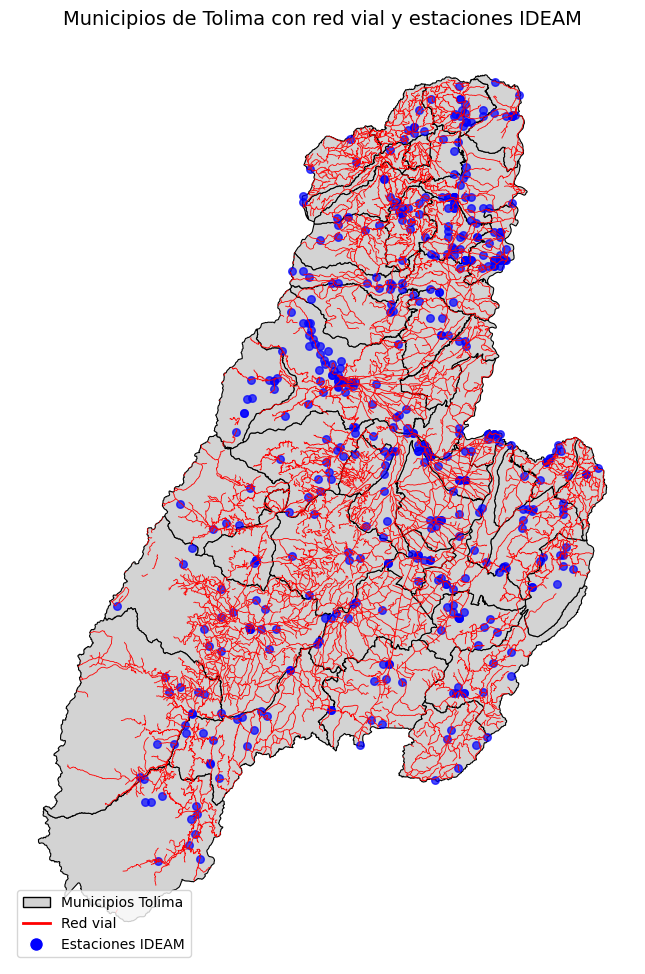

In [45]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Filtrar red vial y estaciones para el Tolima
roads_tolima_viz = gpd.clip(roads, mun_tolima)
gdf_est_tolima = gdf_est[gdf_est.within(mun_tolima.geometry.union_all())]

# Crear mapa
fig, ax = plt.subplots(figsize=(10, 10))
mun_tolima.plot(ax=ax, edgecolor="black", facecolor="lightgrey", linewidth=0.8)
roads_tolima_viz.plot(ax=ax, color="red", linewidth=0.6)
gdf_est_tolima.plot(ax=ax, color="blue", markersize=30, alpha=0.7)

# Título y leyenda personalizada
ax.set_title("Municipios de Tolima con red vial y estaciones IDEAM", fontsize=14)
ax.axis("off")

# Leyenda personalizada
legend_elements = [
    mpatches.Patch(facecolor="lightgrey", edgecolor="black", label="Municipios Tolima"),
    Line2D([0], [0], color="red", lw=2, label="Red vial"),
    Line2D([0], [0], marker='o', color='w', label="Estaciones IDEAM",
           markerfacecolor='blue', markersize=10)
]
ax.legend(handles=legend_elements, loc="lower left")

plt.tight_layout()
plt.show()


In [44]:
# 6. Mostrar tabla con resultados clave
mun_tolima[["MPIO_CNMBR", "road_density_km_km2", "ideam_count"]].sort_values(
    by=["road_density_km_km2"], ascending=False
).head(10)


,MPIO_CNMBR,road_density_km_km2,ideam_count
29,PALOCABILDO,1.369906,0
17,FLANDES,1.204404,5
42,VALLE DE SAN JUAN,1.192854,6
20,HERVEO,1.188212,1
23,LÍBANO,1.145890,12
18,FRESNO,1.138362,5
21,ICONONZO,1.129403,3
15,ESPINAL,1.126247,23
25,MELGAR,1.041492,9
9,CASABIANCA,1.000175,1


## 6.3 Multi-criteria analysis — Level 1

Se selecciona el municipio con las mejores condiciones para implementar un proyecto productivo: 
* Se Normalizan las variables de las distancias. 
* Se asigna igual peso por parámetro. 
* Se selecciona municipio con mejores condiciones. 
* Se realiza una visualización de los municipios del Tolima según el índice final calculado. 

✔️ Mejor municipio candidato: Tolima - IBAGUE


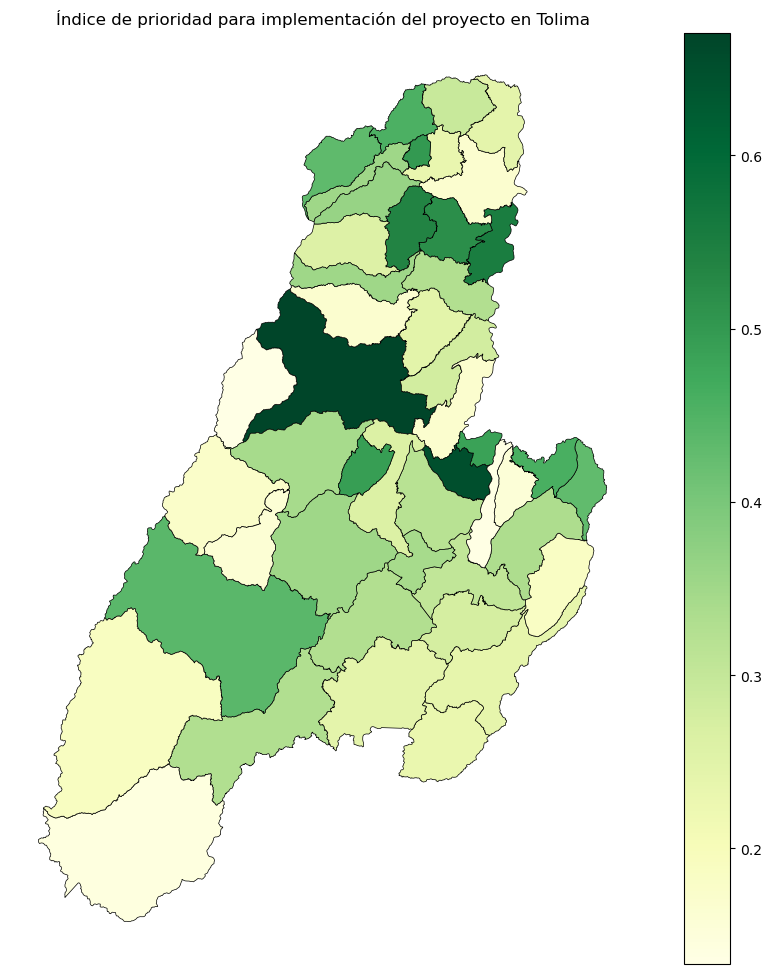

,NOMBRE_MUN,road_density_km_km2,ideam_count,priority_index
0,IBAGUE,0.601068,45,0.670969
15,ESPINAL,1.126247,23,0.651279
3,AMBALEMA,0.817168,26,0.552340
23,LIBANO,1.145890,12,0.537463
22,LERIDA,0.943991,18,0.517726
29,PALOCABILDO,1.369906,0,0.500000
42,VALLE DE SAN JUAN,1.192854,6,0.490896
17,FLANDES,1.204404,5,0.484727
25,MELGAR,1.041492,9,0.459452
18,FRESNO,1.138362,5,0.456464


In [66]:

# from sklearn.preprocessing import MinMaxScaler
# ── Normalizar las variables ──
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

mun_tolima["norm_road"] = normalize(mun_tolima["road_density_km_km2"])
mun_tolima["norm_ideam"] = normalize(mun_tolima["ideam_count"].fillna(0))

# ── Asignar pesos ──
w_road = 0.5
w_ideam = 0.5

# ── Calcular el índice final ──
mun_tolima["priority_index"] = (
    mun_tolima["norm_road"] * w_road +
    mun_tolima["norm_ideam"] * w_ideam
)

# ── Seleccionar el mejor municipio ──
selected_mpio = (
    mun_tolima.sort_values("priority_index", ascending=False)
    .iloc[0]
)

print("✔️ Mejor municipio candidato:", "Tolima", "-", selected_mpio["NOMBRE_MUN"])

# ── Mapa del índice de prioridad ──
fig, ax = plt.subplots(figsize=(10, 10))
mun_tolima.plot(column="priority_index", cmap="YlGn", legend=True, edgecolor="black", linewidth=0.5, ax=ax)
ax.set_title("Índice de prioridad para implementación del proyecto en Tolima")
ax.axis("off")
plt.tight_layout()
plt.show()

# ── Tabla resumen ──
cols = ["NOMBRE_MUN", "road_density_km_km2", "ideam_count", "priority_index"]
display(mun_tolima[cols].sort_values("priority_index", ascending=False))


## 6.4 Core analysis steps — Level 2: Best location within selected municipality

Se realiza el Análisis espacial de segundo nivel (local), enfocado dentro del municipio seleccionado (Ibagué) en la sección anterior, con el fin de identificar el mejor lugar específico para implementar el proyecto agrícola.
* Inicialmente se filtra el municipio
* Se recorda la red vial y las estaaciones que están dentro de dicho municipio

In [67]:
# ── Filtrar municipio seleccionado ──
mun_selected = mun_tolima[mun_tolima["MPIO_CCDGO"] == selected_mpio["MPIO_CCDGO"]]

# ── Recortar red vial y estaciones ──
roads_local = roads[roads.intersects(mun_selected.geometry.iloc[0])]
gdf_est_local = gdf_est[gdf_est.intersects(mun_selected.geometry.iloc[0])]

### Creación de la grilla con un área de 1 km²
* Se crea una grilla de 1 km²

In [68]:
# ── Crear una grilla regular ──
from shapely.geometry import box
import numpy as np

def create_grid(gdf, cell_size):
    bounds = gdf.total_bounds  # xmin, ymin, xmax, ymax
    xmin, ymin, xmax, ymax = bounds
    cols = list(np.arange(xmin, xmax, cell_size))
    rows = list(np.arange(ymin, ymax, cell_size))
    polygons = []
    for x in cols:
        for y in rows:
            polygons.append(box(x, y, x + cell_size, y + cell_size))
    grid = gpd.GeoDataFrame({"geometry": polygons}, crs=gdf.crs)
    return gpd.overlay(grid, gdf, how="intersection")

cell_size = 1000  # metros (1 km²)
grid_local = create_grid(mun_selected, cell_size)

#### Diferentes criterios e índice Local
* Se determinan 3 criterios, distancia a vías, a estaciones y disponibilidad.

In [72]:
# ── Criterio 1: distancia a vías ──
grid_local["dist_road"] = grid_local.geometry.centroid.apply(
    lambda pt: roads_local.distance(pt).min() / 1000  # km
)

# ── Criterio 2: distancia a estaciones ──
grid_local["dist_ideam"] = grid_local.geometry.centroid.apply(
    lambda pt: gdf_est_local.distance(pt).min() / 1000
)

# ── Criterio 3: disponibilidad: Se invierte el valor, entre menor sea la distancia mayor puntaje para ambos

grid_local["score_road"] = normalize(-grid_local["dist_road"])
grid_local["score_ideam"] = normalize(-grid_local["dist_ideam"])

# ── Índice final local ──
w1, w2 = 0.5, 0.5
grid_local["local_index"] = grid_local["score_road"] * w1 + grid_local["score_ideam"] * w2

* Se selecciona la mejor celda con un área menor a 5 km².
* Finalmente se visualiza dicha área en el municipio de Ibagué. 

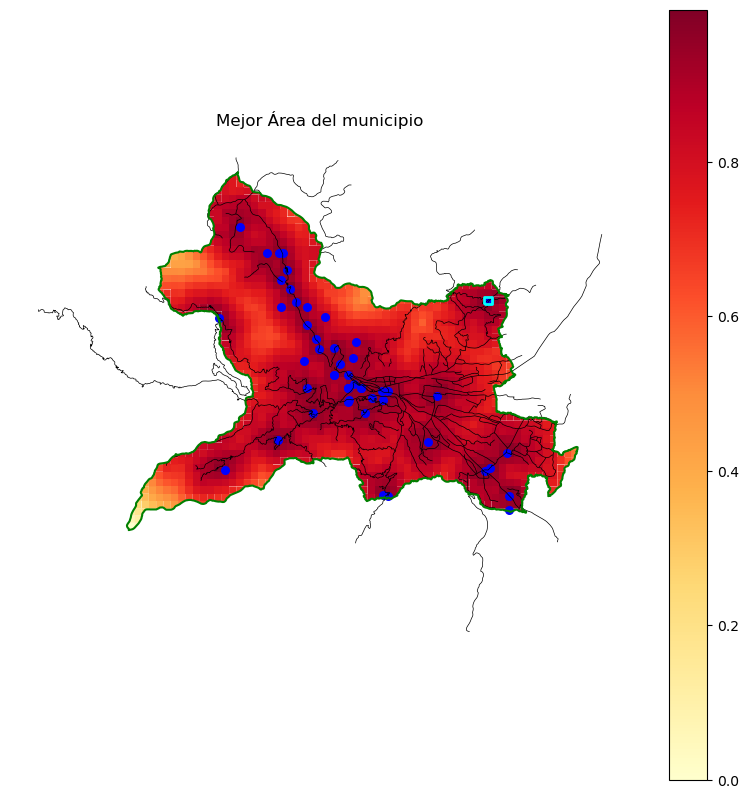

Área seleccionada dentro del municipio:


,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,norm_ideam_count,priority_index,norm_road,norm_ideam,geometry,dist_road,dist_ideam,score_road,score_ideam,local_index
1366,73,001,IBAGUÉ,73001,2018,1.377251e+09,4.451921,-75.252591,218584.0,0.0,...,1.0,0.670969,0.341938,1.0,"POLYGON ((4769146.505 2059792.885, 4769146.505...",0.006536,0.179337,0.999387,0.994278,0.996833


In [71]:
# ── Seleccionar mejor celda (área ≤ 5 km²) ──
best_cell = grid_local.sort_values("local_index", ascending=False).iloc[0:1]

# ── Visualización ──
fig, ax = plt.subplots(figsize=(10, 10))
grid_local.plot(column="local_index", cmap="YlOrRd", ax=ax, legend=True)
roads_local.plot(ax=ax, color="black", linewidth=0.5)
gdf_est_local.plot(ax=ax, color="blue", markersize=30)
best_cell.boundary.plot(ax=ax, color="cyan", linewidth=2)
mun_selected.boundary.plot(ax=ax, color="green")
ax.set_title("Mejor Área del municipio")
ax.axis("off")
plt.show()

print("Área seleccionada dentro del municipio:")
display(best_cell)
